# Exponential Smoothing

Exponential smoothing techniques use rolling averages whose weights decrease exponentially into the past. 

## What we will accomplish

In this notebook we will:
- Learn about simple exponential smoothing,
- Extend that to double exponential smoothing and
- End with triple exponential smoothing or the Holt Winters forecast.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error

set_style("whitegrid")

In [4]:
# Google stock data
goog = pd.read_csv("../../data/google_stock.csv", parse_dates=['date'])

goog_train = goog.iloc[:-14].copy()
goog_test = goog.iloc[-14:].copy()

We will introduce three exponential smoothing forecasting methods.

It is important to note that these were originally **forecasting methods** without any underlying statistical models.  It is only recently that statistical models called "State Space models" have been developed which provide a statistical underpinning to these methods.  We will not cover State Space models in this bootcamp, but if you are interested I highly recommend "Forecasting with Exponential Smoothing: The State Space Approach" by Rob J. Hyndman, Anne B. Koehler, J. Keith Ord and Ralph D. Snyder.

### Simple exponential smoothing

First we will define simple exponential smoothing recursively as 

$$
\begin{align*}
s_{1} &= y_1\\
s_{t} &= \alpha y_{t} + (1-\alpha) s_{t-1} \text{ for }  2 \leq t\leq n\\
s_{t} &= s_n \text{ for } t > n
\end{align*}
$$

where $\alpha \in [0,1]$ is a hyperparameter that you can select by hand or through some kind of algorithm (minimizing the MSE on the training data is a common approach).

We can think of $s_{t}$ as our current best estimate of the "level" of our time series.  At each step we update our prediction by taking a weighted average of our new observation $y_t$ with our old estimate $s_{t-1}$.  

$\alpha$ represents how strongly we weight our new information:  if $\alpha = 1$ then we discard all previous information, and if $\alpha = 0$ we discard all new information.  A larger value of $\alpha$ corresponds to a greater confidence in newer observations.

When it is written out all the way the simple exponential smoothing is:

$$
s_t = \alpha \left[y_{t} +(1-\alpha) y_{t-1} + (1-\alpha)^2 y_{t-2} + \dots + (1-\alpha)^{t-1} y_1\right].
$$

This is a weighted sum of all prior observations, where the weight is exponentially decreasing by a factor of $(1-\alpha)$ for each additional time step into the past.

Note that $\alpha + \alpha(1-\alpha) + \alpha(1-\alpha)^2 + \dots $ is a geometric series whose sum is $\frac{\alpha}{1- (1-\alpha)} = 1$, so this approximates a weighted average as $t \to \infty$.

#### Simple exponential smoothing in python

So far we have been using sklearn as our predictive modeling library, but it does not have support for time series.

Options for time series libraries:
- [statsmodels](https://www.statsmodels.org/stable/index.html) is the option we are using in these notes.
- [sktime](https://www.sktime.net/en/stable/) is a library which works well with sklearn.  It often calls statsmodels under the hood.
- [Darts](https://unit8co.github.io/darts/) is a library which includes all of the old classics plus some more modern methods like deep neural networks. 


In [5]:
## Importing statsmodels to check that we have it installed
import statsmodels as sm

In [6]:
## printing the statsmodels version
## I had version 0.13.5 when I wrote this notebook
print(sm.__version__)

0.14.1


If needed, installation instructions for pip and conda can be found here <a href="https://www.statsmodels.org/stable/install.html">https://www.statsmodels.org/stable/install.html</a>.

Simple exponential smoothing can be implemented with the `SimpleExpSmoothing` model type in `statsmodels`, <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing">https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing</a>.

In [7]:
## Importing the model from statsmodels
from statsmodels.tsa.api import SimpleExpSmoothing

## To fit a SimpleExpSmoothing model you
## First call SimpleExpSmoothing with the training data
## then .fit
## with smoothing_level, this is alpha
## and optimized=False, if this is True alpha is found using the method of maximum likelihood
simp_exp_smooth = SimpleExpSmoothing(goog_train.closing_price.values).fit(smoothing_level=.8,
                                                                             optimized=False)

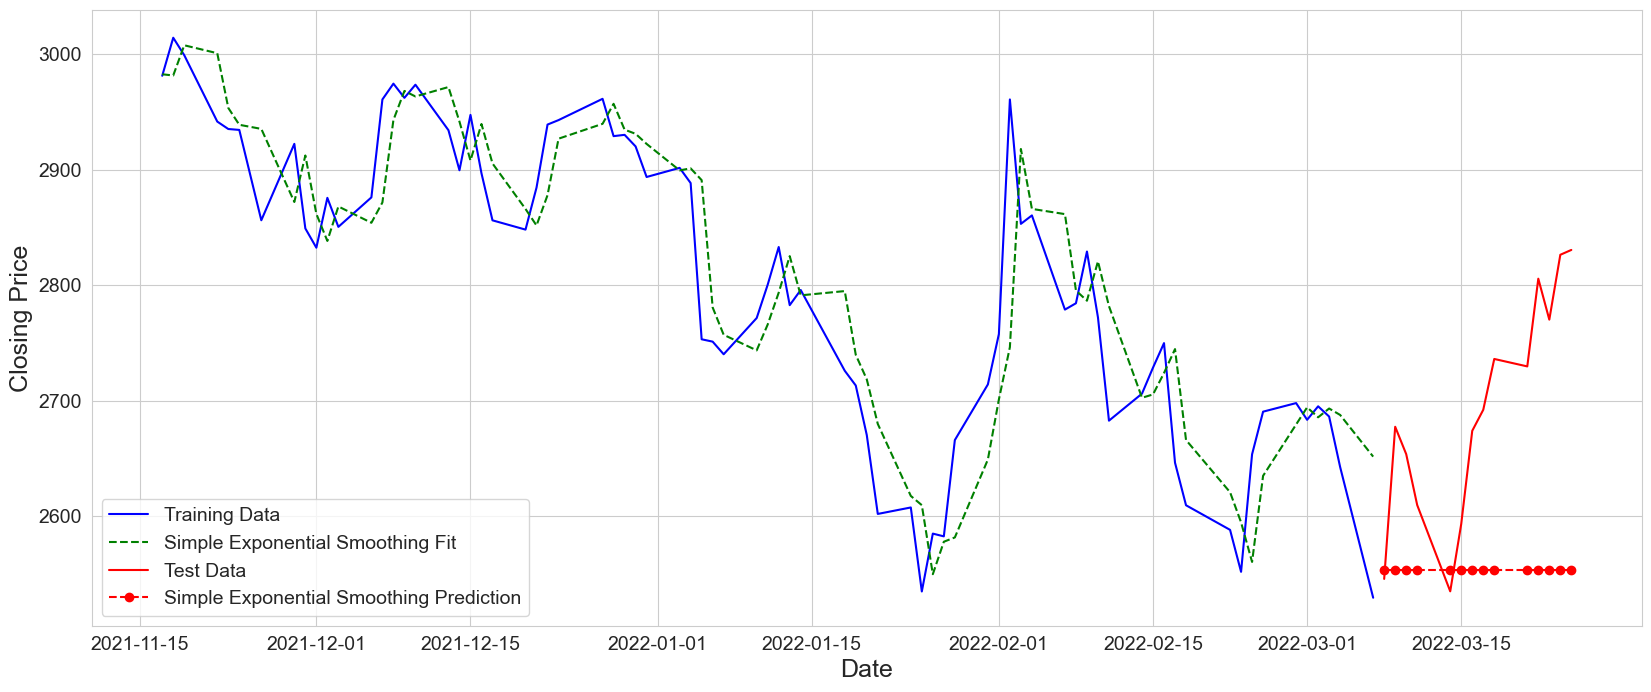

In [8]:
plt.figure(figsize=(20,8))


plt.plot(goog_train.date[-75:], 
         goog_train.closing_price[-75:],
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(goog_train.date[-75:], 
         simp_exp_smooth.fittedvalues[-75:],
         'g--',
         label="Simple Exponential Smoothing Fit")

plt.plot(goog_test.date, 
         goog_test.closing_price,
         'r',
         label="Test Data")

## We can get the forecast with .forecast(h)
plt.plot(goog_test.date, 
         simp_exp_smooth.forecast(14),
         'r--o',
         label="Simple Exponential Smoothing Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Here we could use cross-validation or a validation set to find the "best" $\alpha$.

### Double exponential smoothing

Simple exponential smoothing does not deal well with time series that exhibit a trend. An expansion built to handle trends is <i>double exponential smoothing</i>.

We can think of this as iteratively updating a presumed level $s_t$ and slope $b_t$

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} s_{t-1} + b_{t-1} & \text{for} & 1<t\leq n \\
                                                s_n + (t-n)b_{n}& \text{for} & t > n \end{array}\right\rbrace, 
$$

where 

$$
s_{t} = \alpha y_t + (1-\alpha) (s_{t-1} + b_{t-1}), \ s_1 = y_1,
$$

$$
b_{t} = \beta (s_t - s_{t-1}) + (1-\beta) b_{t-1}, \ b_1 = y_2 - y_1 \text{ and}
$$

$\alpha \in [0,1]$ and $\beta \in [0,1]$ are hyperparameters that we can select by hand or though an optimization process.

These can be interpretted as 

$$
\textrm{New smoothed level} = \alpha(\textrm{New observed value}) + (1- \alpha) (\textrm{ Old smoothed level plus old predicted slope})
$$

$$
\textrm{New predicted slope} = \beta(\textrm{Slope computed using two newest smoothed values }) + (1- \beta) (\textrm{ Old predicted slope})
$$

Then we forecast using the last smoothed level and last predicted slope, increasing our prediction by the slope for each $1$ time step into the future.

This is called "Double exponential smoothing" because both update equations look similar to simple exponential smoothing.

As before, higher levels of $\alpha$ and $\beta$ correspond to greater confidence in more recent observations.
 
#### Double exponential smoothing in python

We can implement this in python with `statsmodel`'s `Holt` model object, <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.Holt.html">https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.Holt.html</a>.

In [9]:
from statsmodels.tsa.holtwinters import Holt

In [12]:
## Here in addition to setting a smoothing_level
## we also set a smoothing_trend, which is the value of beta
## again we set optimized = False, unless we'd rather choose alpha and beta through
## maximum likelihood estimation
exp_smooth = Holt(goog_train.closing_price.values).fit(smoothing_level=0.8, 
                                                          smoothing_trend=0.8,
                                                          optimized=False)

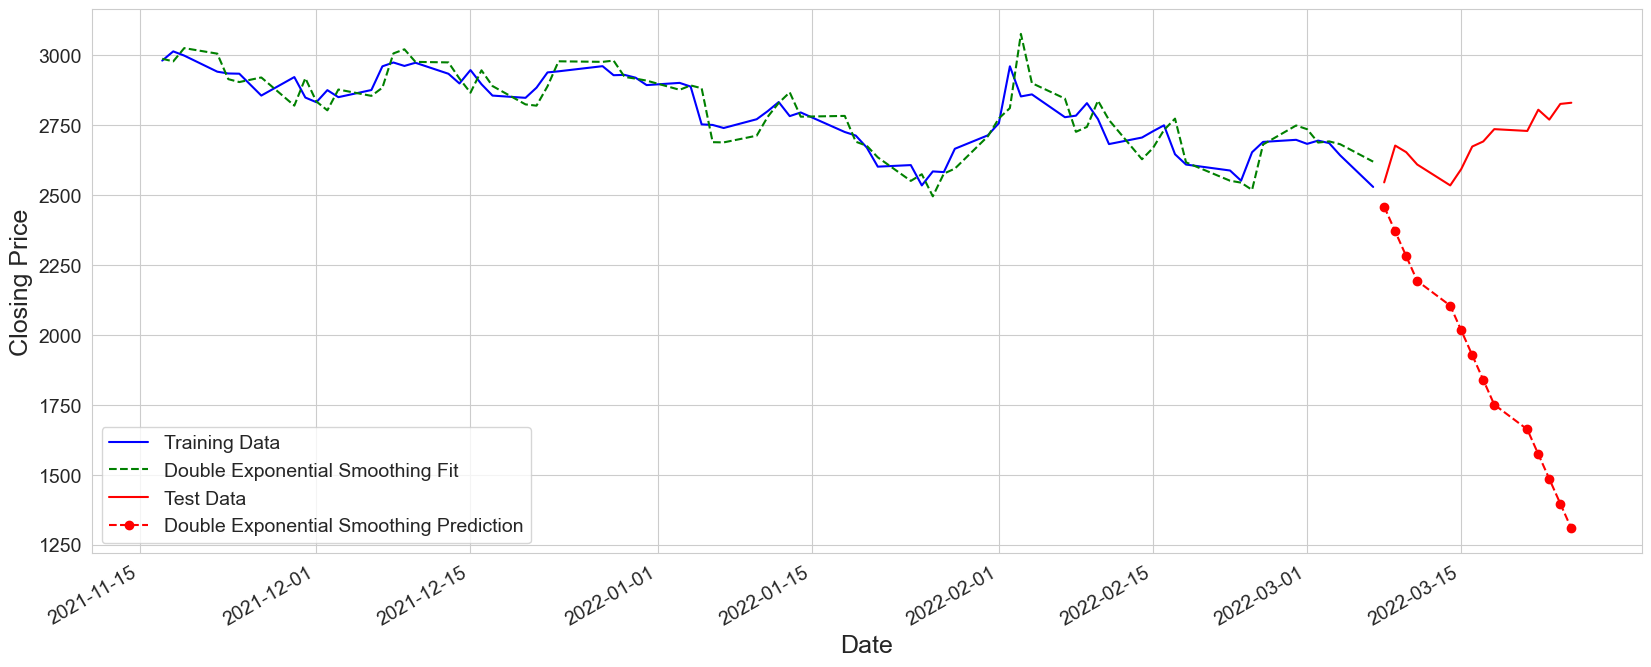

In [13]:
plt.figure(figsize=(20,8))


plt.plot(goog_train.date[-75:], 
         goog_train.closing_price[-75:],
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(goog_train.date[-75:], 
         exp_smooth.fittedvalues[-75:],
         'g--',
         label="Double Exponential Smoothing Fit")

plt.plot(goog_test.date, 
         goog_test.closing_price,
         'r',
         label="Test Data")

## We can get the forecast with .forecast(h)
plt.plot(goog_test.date, 
         exp_smooth.forecast(14),
         'r--o',
         label="Double Exponential Smoothing Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)
plt.gcf().autofmt_xdate()


plt.show()

<i>Note: The observations may look like not a straight line, but that is because we do not trade stocks on the weekend</i>

As we can see from this example, that depending on the value of $\beta$ double exponential smoothing may pay too much attention to a recent trend. Again you can play around with finding the optimal $\alpha$ and $\beta$ with cross-validation or a validation set.

### Triple exponential smoothing or the Holt-Winters forecast

The final forecast we will look at in this notebook is <i>triple exponential smoothing</i> or the <i>Holt-Winters</i> model. Holt-Winters adds a third smoothing component to account for seasonal trends in time series. The third component can take one of two forms because there can be different kinds of seasonality present in a time series.


#### 1. Additive version

Additive seasonality is when the value at the subsequent time step in the cycle is some amount added to the previous step. For example, maybe an ice cream shop consistently sees $\$ 10000$ less in sales from summer to fall.

The additive Holt-Winters model is:

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} s_{t-1} + b_{t-1} + c_{t-m} & \text{for} & 1<t\leq n \\
                                                s_n + (t-n)b_n  + c_{n-m+1 + (t-n-1)\%m} & \text{for} & t > n \end{array}\right\rbrace, 
$$

where

$$
s_{t} = \alpha (y_t - c_{t-m}) + \left(1-\alpha\right) \left( s_{t-1} + b_{t-1}\right), \ s_1 = y_1,
$$

$$
b_{t} = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}, \ b_1 = y_2 - y_1,
$$

$$
c_{t} = \gamma (y_t - s_{t-1} - b_{t-1}) + (1-\gamma)c_{t-m},
$$

$\%$ denotes modular division, $m$ is the number of time steps that make up a season and $\alpha$, $\beta$ and $\gamma$ are all hyperparameters.

These can be interpretted as 

- $s_t$ is the smoothed prediction with seasonal changes removed.
- $b_t$ is the smoothed slope with seasonal changes removed.
- $c_t$ is an approximation of the net gain we should expect due to it being the current season.

The update equations tell us to take weighted averages of current and past estimated values of each.

#### 2. Multiplicative version

Multiplicative seasonality occurs when we expect that each season is impacted by some fixed multiplier.  For instance, we might expect sales of ice cream to take a $30\%$ hit when moving from summer to fall.

The multiplicative version of the Holt-Winters model is:

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} \left( s_{t-1} + b_{t-1} \right) c_{t-m} & \text{for} & 1<t\leq n \\
                                                \left( s_n + (t-n)b_n \right)c_{n-m+1 + (t-n-1)\%m} & \text{for} & t > n \end{array}\right\rbrace, 
$$

where

$$
s_{t} = \alpha \frac{y_t}{c_{t-m}} + \left(1-\alpha\right) \left( s_{t-1} + b_{t-1}\right), \ s_1 = y_1,
$$

$$
b_{t} = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}, \ b_1 = y_2 - y_1,
$$

$$
c_{t} = \gamma \frac{y_t}{s_t} + (1-\gamma)c_{t-m},
$$

$\%$ denotes modular division, $m$ is the number of time steps that make up a season and $\alpha \in [0,1]$, $\beta \in [0,1]$ and $\gamma \in [0,1]$ are all hyperparameters.

This has much the same interpretation as the other models:  we update by performing weighted averages of our new smoothed parameters with our old ones.  The only difference is that $c_t$ now represents our estimate of the multiplier associated with the season $t$ (i.e. the times $t$, $t-m$, $t-2m$, etc represent the same position within the cycle).


#### Implementing in python

You can implement either version of the Holt-Winters model in python using `statsmodels` `ExponentialSmoothing` model, <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html">https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html</a>.

In [14]:
from statsmodels.tsa.api import ExponentialSmoothing

To test this model out we will return to our flu data set.

In [15]:
flu = pd.read_csv("../../data/us_flu_1928_1948.csv", parse_dates=['date'])

flu_train = flu.loc[flu.year < 1947].copy()
flu_test = flu.loc[flu.year == 1947].copy()

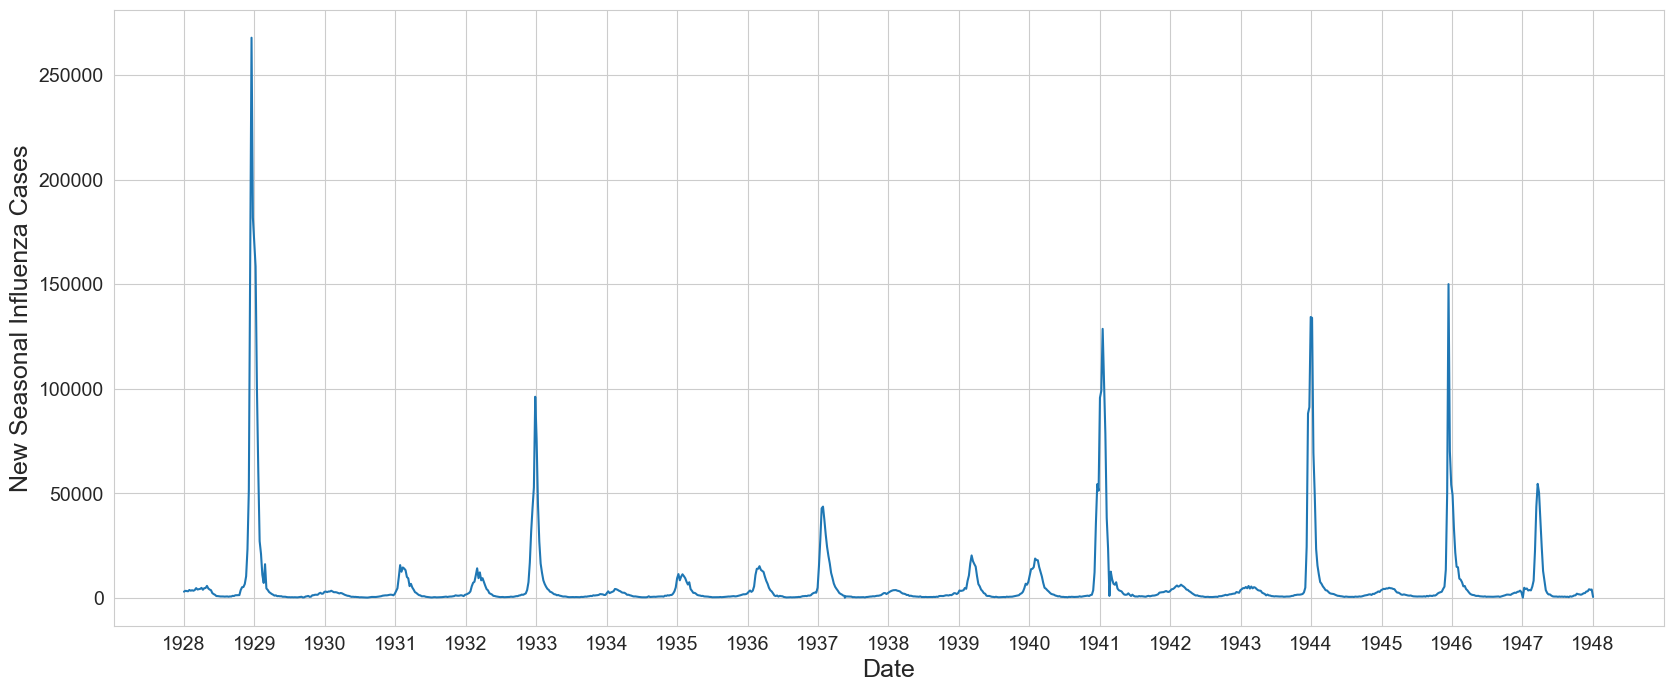

In [16]:
plt.figure(figsize=(20,8))

plt.plot(flu.date, flu.cases)

plt.xlabel("Date", fontsize=18)
plt.ylabel("New Seasonal Influenza Cases", fontsize=18)

plt.xticks([datetime(1928,1,1) + timedelta(days=365*i) for i in range(21)],
           [str(i) for i in range(1928, 1949)],
           fontsize=14)
plt.yticks(fontsize=14)

plt.show()

For these data we will use the mutliplicative model.

In [17]:
## Call ExponentialSmoothing
## input the training data
## set seasonal = "mul", for additive you would set it equal to "add"
## You set m using seasonal_periods = 
## Then call fit
## set a smoothing_level, alpha
## set a smoothing_trend, beta
## set a smoothing_seasonal, gamma
## Set optimized = False, unless you want maximum likelihood to estimate alpha, beta, gamma
holt_winter = ExponentialSmoothing(flu_train.cases.values,
                                      seasonal='mul',
                                      seasonal_periods=52).fit(smoothing_level=0,
                                                                  smoothing_trend=0,
                                                                  smoothing_seasonal=.8,
                                                                  optimized=False)

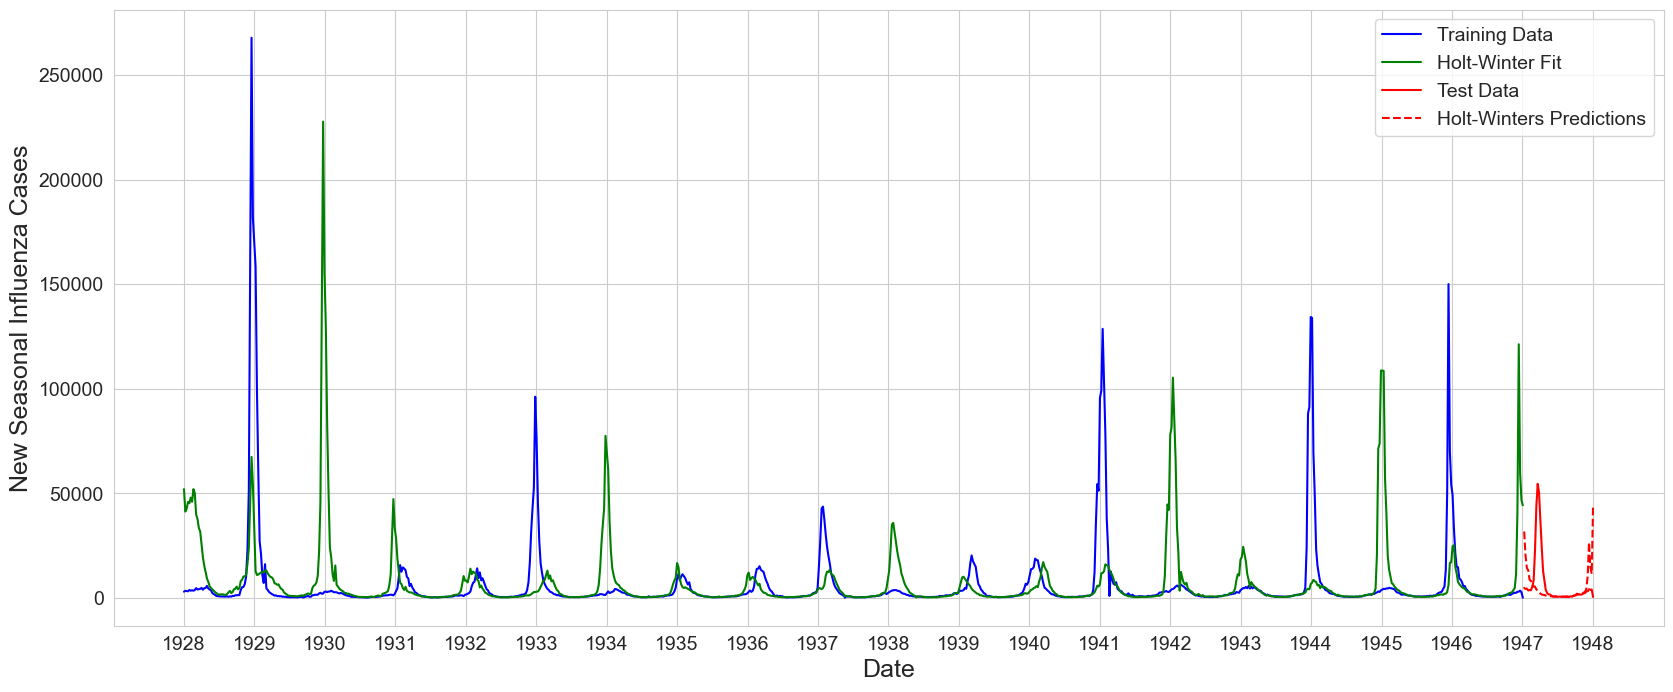

In [18]:
plt.figure(figsize=(20,8))

plt.plot(flu_train.date, 
         flu_train.cases,
         'b-',
         label="Training Data")
plt.plot(flu_train.date, 
         holt_winter.fittedvalues, 
         'g-',
         label="Holt-Winter Fit")

plt.plot(flu_test.date, 
         flu_test.cases,
         'r-',
         label="Test Data")

plt.plot(flu_test.date, 
         holt_winter.forecast(52),
         'r--',
         label="Holt-Winters Predictions")


plt.xlabel("Date", fontsize=18)
plt.ylabel("New Seasonal Influenza Cases", fontsize=18)

plt.xticks([datetime(1928,1,1) + timedelta(days=365*i) for i in range(21)],
           [str(i) for i in range(1928, 1949)],
           fontsize=14)
         
plt.yticks(fontsize=14)
         
plt.legend(fontsize=14)

plt.show()

As we have said before we can use cross-validation or a validation set to find the "best" values for our hyperparameters.

### Other exponential smoothing methods

This diagram from

"Forecasting with Exponential Smoothing: The State Space Approach" by Rob J. Hyndman, Anne B. Koehler, J. Keith Ord and Ralph D. Snyder 
 
summarizes all of the exponential smoothing methods.  We have covered the four most commonly used methods.

![title](lecture_6_assets/ETS.png)


--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)